In [1]:
import os
import json
from model_functions import PaddedDataset, trainer_gpt2_transformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer


PATH_VOCAB = "../0_data/5_vocabs"
PATH_WORD_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_LOSS = "../0_data/7_models/loss"
PATH_MODELS_CONFIG = "../0_data/7_models/config"

for path in [PATH_MODELS, PATH_MODELS_LOSS, PATH_MODELS_CONFIG]:
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
model_df = pd.read_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx", index_col="Unnamed: 0")
model_df

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,perplexity,incorrect_notes,correct_notes,correct_rate
0,a1,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a2,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a3,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,d,1024,256,4,6,0,0.001,50,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.828700,2.464633
2,2.281800,2.190600
3,2.139600,2.140356
4,2.102400,2.114166
5,2.070800,2.089571
6,2.039000,2.022615
7,1.883400,1.642451
8,1.629400,1.534933
9,1.568300,1.522422
10,1.534300,1.485929


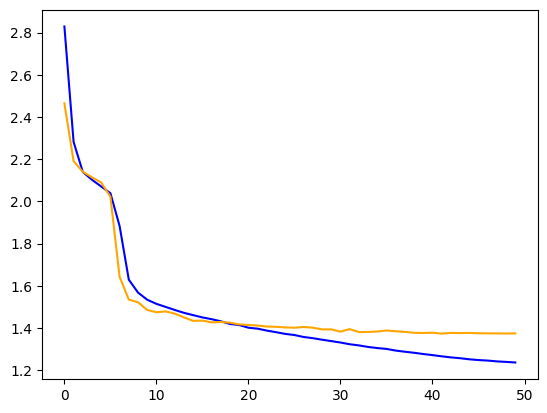

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.568000,2.138010
2,2.034800,1.998575
3,1.926100,1.934256
4,1.886700,1.899024
5,1.853100,1.888023
6,1.830400,1.866771
7,1.807600,1.809568
8,1.687400,1.553442
9,1.473400,1.409935
10,1.409600,1.370244


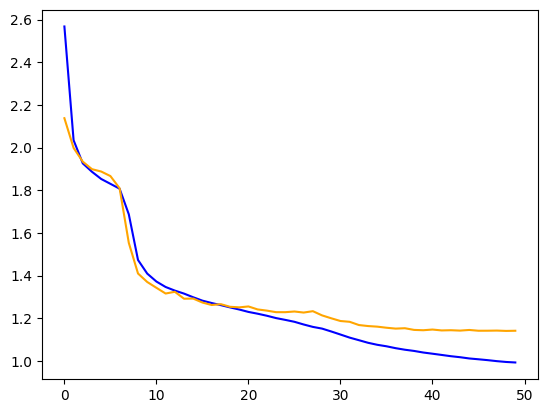

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.539600,2.183415
2,2.155500,2.136729
3,2.100000,2.101691
4,2.062000,2.061037
5,1.977500,1.810845
6,1.673300,1.548267
7,1.569400,1.510934
8,1.522400,1.477693
9,1.481200,1.474639
10,1.449100,1.447572


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



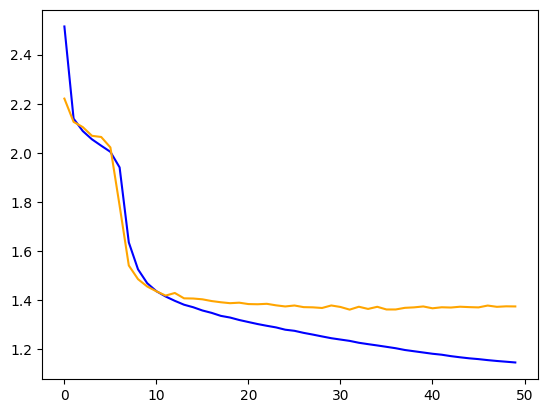

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.192900,1.968058
2,1.876500,1.875040
3,1.823100,1.854711
4,1.801400,1.834250
5,1.778500,1.813654
6,1.762500,1.809055
7,1.738900,1.774902
8,1.648700,1.483994
9,1.406700,1.343840
10,1.337900,1.300618


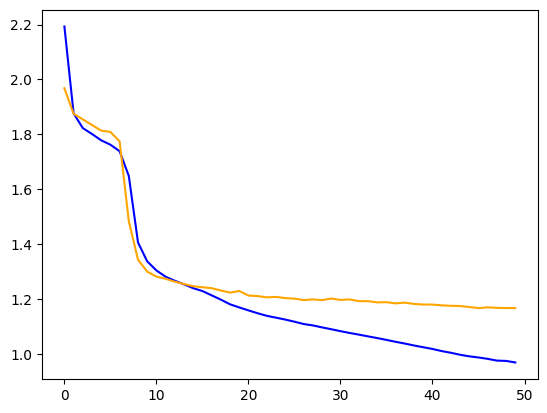

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,perplexity,incorrect_notes,correct_notes,correct_rate
0,a1,1024,256,4,6,0,0.001,50,4,yes,717.6662,11.96,1.373842,42.0,423.106567,NaN,NaN,NaN
1,a2,1024,256,4,6,0,0.001,50,4,yes,716.0189,11.93,1.140858,49.0,472.513916,NaN,NaN,NaN
2,a3,1024,256,4,6,0,0.001,50,4,yes,696.7114,11.61,1.342281,34.0,252.672455,NaN,NaN,NaN
3,b,1024,256,4,6,0,0.001,50,4,yes,636.9317,10.62,1.325169,27.0,306.182312,NaN,NaN,NaN
4,c,1024,256,4,6,0,0.001,50,4,yes,656.0490,10.93,1.362022,32.0,810.230347,NaN,NaN,NaN
5,d,1024,256,4,6,0,0.001,50,4,yes,598.8393,9.98,1.167735,50.0,486.180145,NaN,NaN,NaN


In [4]:
rows = []

for index, row in model_df.iterrows():
    
    # only run models that not ran yet
    if row["ran"] == "yes":
        continue
    
    # create model name directories
    model_name = row["name"]
    model_dirs = {
        "loss": f"{PATH_MODELS_LOSS}/{model_name}",
        "out": f"{PATH_MODELS_CONFIG}/{model_name}"
    }
    for key in model_dirs:
        if not os.path.exists(model_dirs[key]):
            os.makedirs(model_dirs[key])
    
    # save hyperparameters as dictionary
    model_hyperparameters = {
        "max_length": row["max_length"],
        "emb_dim": row["emb_dim"],
        "attention_heads": row["attention_heads"],
        "layers": row["layers"],
        "dropout": row["dropout"],
        "learning_rate": row["learning_rate"],
        "epochs": row["epochs"],
        "batch_size": row["batch_size"],
    }
    
    # create tokenizer
    tokenizer = GPT2Tokenizer(
        vocab_file=f"{PATH_VOCAB}/vocab_{model_name}.json", 
        merges_file=f"{PATH_VOCAB}/merges.txt")
    tokenizer.add_special_tokens({'pad_token': 'PAD', 'bos_token': 'BOS', 'eos_token': 'EOS',})
    
    # read in data
    with open(f"{PATH_WORD_DATA}/{model_name}_data.json", 'r') as fp:
        json_data = json.load(fp)
    song_list = []
    for song in json_data:
        song_list.append(json_data[song])
    data = [" ".join(song) for song in song_list]
    split_train_test = int(0.9*len(data))
    
    # create datasets and define data collator
    train_dataset = PaddedDataset(tokenizer=tokenizer, data=data[:split_train_test], max_length=row["max_length"])
    eval_dataset = PaddedDataset(tokenizer=tokenizer, data=data[split_train_test:], max_length=row["max_length"])
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    model_data = {
        "train_dataset": train_dataset,
        "eval_dataset": eval_dataset,
        "data_collator": data_collator,
    }
    
    # create and train model trainer
    trainer = trainer_gpt2_transformer(
        hyperparameters = model_hyperparameters,
        tokenizer = tokenizer,
        data = model_data,
        dirs = model_dirs,
    )
    trainer.train()
    
    # compute perplexity
    inputs = tokenizer.encode("Bar_None".split(" "), return_tensors="pt")
    outputs = trainer.predict(tokenizer.encode("Bar_None".split(" "), return_tensors="pt"))
    logits = outputs.predictions
    probabilities = torch.softmax(torch.from_numpy(logits), dim=-1)
    log_probabilities = torch.log(probabilities)
    num_samples = log_probabilities.size(1)
    total_log_prob = torch.sum(log_probabilities[0, torch.arange(num_samples), inputs[0]])
    perplexity = torch.exp(-total_log_prob / num_samples).item()
    
    # save runtime and model loss
    log_hist = trainer.state.log_history
    eval_loss = [log_hist[i]["eval_loss"] for i in range(1,len(log_hist),2)]
    train_loss = [log_hist[i]["loss"] for i in range(0,len(log_hist)-1,2)]
    runtime = log_hist[-1]["train_runtime"]
    
    model_df.at[index,"perplexity"] = perplexity
    model_df.at[index,"runtime"] = runtime
    model_df.at[index,"runtime_min"] = (runtime/60).__round__(2)
    model_df.at[index,"min_loss"] = min(eval_loss)
    model_df.at[index,"at_epoch"] = np.argmin(eval_loss) + 1

    # show loss plot
    plt.plot(train_loss, color="blue")
    plt.plot(eval_loss, color="orange")
    plt.savefig(f"{model_dirs['loss']}/loss_graph_{model_name}.jpg")
    plt.show()
    
    # save model and set ran to yes
    trainer.save_model(f"{model_dirs['out']}/end_version")
    model_df.at[index,"ran"] = "yes"
    
model_df

In [5]:
model_df.to_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx")